# 2.1

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import griddata

In [42]:
df = pd.read_csv('runtimes.csv', comment='#')
print(df.head())

   size  workers      time         algo
0  4096        1  3.736606  distributed
1  4096        2  2.133074  distributed
2  4096        3  1.673441  distributed
3  4096        4  1.515788  distributed
4  4096        5  1.475265  distributed


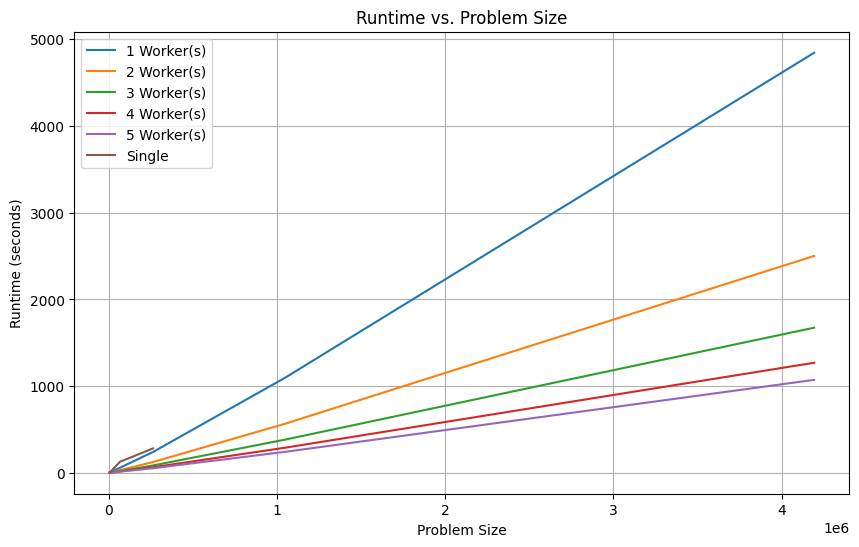

In [43]:
# Assuming your dataset has columns 'problem_size', 'single_runtime', 'distributed_runtime', 'num_threads'
plt.figure(figsize=(10, 6))
# Filter the dataframe for 'distributed' algorithm and iterate over unique 'workers'
for worker in df[df['algo'] == 'distributed']['workers'].unique():
    data = df[(df['workers'] == worker) & (df['algo'] == 'distributed')]
    plt.plot(data['size'], data['time'], label='{} Worker(s)'.format(worker))

# Filter for 'single' algorithm
plt.plot(df[df['algo'] == 'single']['size'], df[df['algo'] == 'single']['time'], label='Single')
plt.title('Runtime vs. Problem Size')
plt.xlabel('Problem Size')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.grid(True)
plt.show()

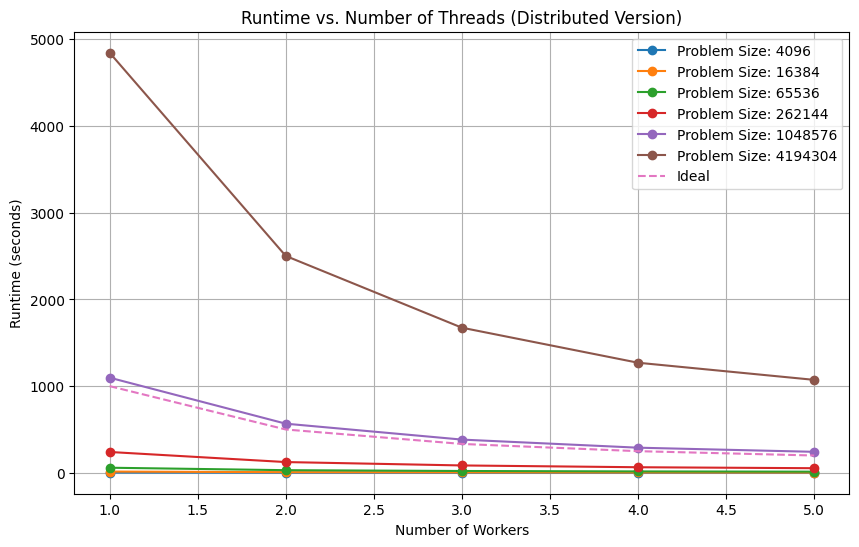

In [44]:
plt.figure(figsize=(10, 6))
for size in df['size'].unique():
    data = df[(df['size'] == size) & (df['algo'] == 'distributed')].sort_values('workers')
    plt.plot(data['workers'], data['time'], label='Problem Size: {}'.format(size), marker='o', linestyle='-')

# Ideal dependency: runtime decreases with increasing number of workers.
# representing this with a hypothetical data
ideal_workers = range(1, df['workers'].max() + 1)
ideal_runtime = [1000.0 / worker for worker in ideal_workers]  # Hypothetical values

plt.title('Runtime vs. Number of Threads (Distributed Version)')
plt.plot(ideal_workers, ideal_runtime, label='Ideal', linestyle='--')
plt.xlabel('Number of Workers')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.grid(True)
plt.show()


## 2.2.1

In [45]:
def process_line(line):
    try:
        splits = [x for x in line.split(' ') if x] 
        if len(splits) < 6:
            print(f'Skipped malformed line: {line}')
            return None
        
        stations_id, von_datum, bis_datum, stationshoehe, lat, long, *rest = splits
        name_and_state = ' '.join(rest).rsplit(',', maxsplit=1)
            
        if len(name_and_state) == 2:
            name, state = name_and_state
        else:
            name, state = name_and_state[0], ''
        
        return [stations_id, von_datum, bis_datum, stationshoehe, lat, long, name, state]
    
    except Exception as e:
        print(f"Error processing line {line} : {str(e)}")
        return None

def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.readlines()
        
    # Skip first two lines and process the rest
    content = [x.strip() for x in content][2:]
    
    data_list = [process_line(line) for line in content]
    
    return pd.DataFrame(data_list, columns=["Stations_id", "von_datum", "bis_datum", "Stationshoehe", "geoBreite", "geoLaenge", "Stationsname", "Bundesland"])

def main():
    input_file = 'zehn_min_rr_Beschreibung_Stationen.txt'
    output_file = 'output.csv'
    
    df = read_data(input_file)
    
    if df is not None:
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
        print(df.head())

if __name__ == "__main__":
    main()


Data saved to output.csv
  Stations_id von_datum bis_datum Stationshoehe geoBreite geoLaenge  \
0       00020  20040812  20240422           432   48.9219    9.9129   
1       00044  20070208  20240422            44   52.9336    8.2370   
2       00053  20050831  20240422            60   52.5850   13.5634   
3       00073  20070213  20240422           374   48.6183   13.0620   
4       00078  20041010  20240422            64   52.4853    7.9125   

                              Stationsname Bundesland  
0  Abtsgmnd-Untergrningen Baden-Wrttemberg             
1                Groenkneten Niedersachsen             
2                  Ahrensfelde Brandenburg             
3             Aldersbach-Kramersepp Bayern             
4                  Alfhausen Niedersachsen             


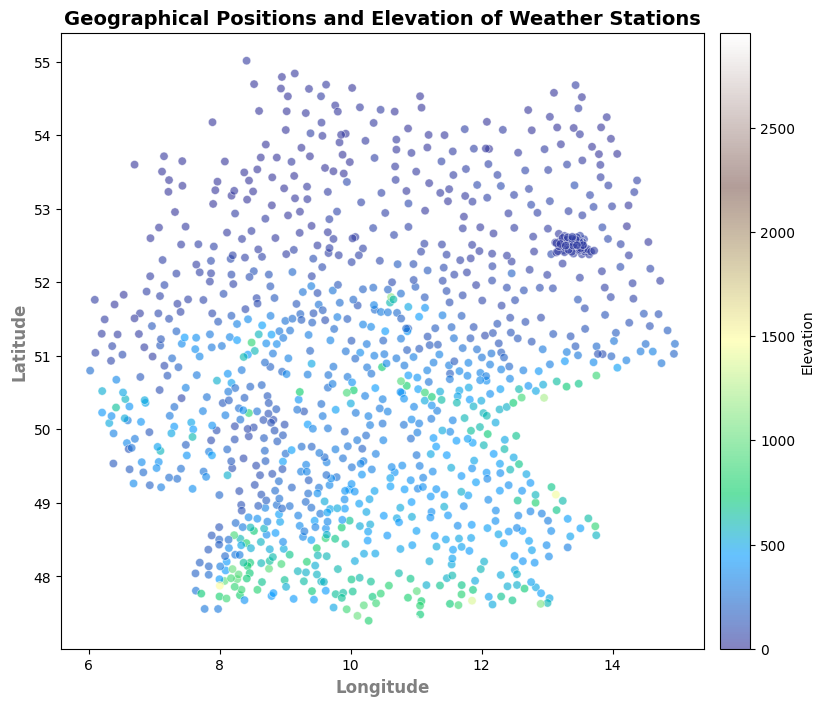

In [46]:
# Load the CSV into a pandas DataFrame
df = pd.read_csv('output.csv')

df['Stationshoehe'] = df['Stationshoehe'].astype(int)
df['geoBreite'] = df['geoBreite'].astype(float)
df['geoLaenge'] = df['geoLaenge'].astype(float)

# Create a scatter plot
plt.figure(figsize=[10,8])
plt.scatter(df['geoLaenge'], df['geoBreite'], c=df['Stationshoehe'], cmap='terrain', alpha=0.6, edgecolors='w', linewidths=0.5)

# Provide labels for axes and title for the plot. Also include a colorbar.
plt.xlabel('Longitude', fontsize=12, fontweight='bold', color='gray')
plt.ylabel('Latitude', fontsize=12, fontweight='bold', color='gray')
plt.title('Geographical Positions and Elevation of Weather Stations', fontsize=14, fontweight='bold', color='black')
plt.colorbar(label='Elevation', pad=0.02)

# Customize tick labels
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Display the plot
plt.show()


# 2.2.2

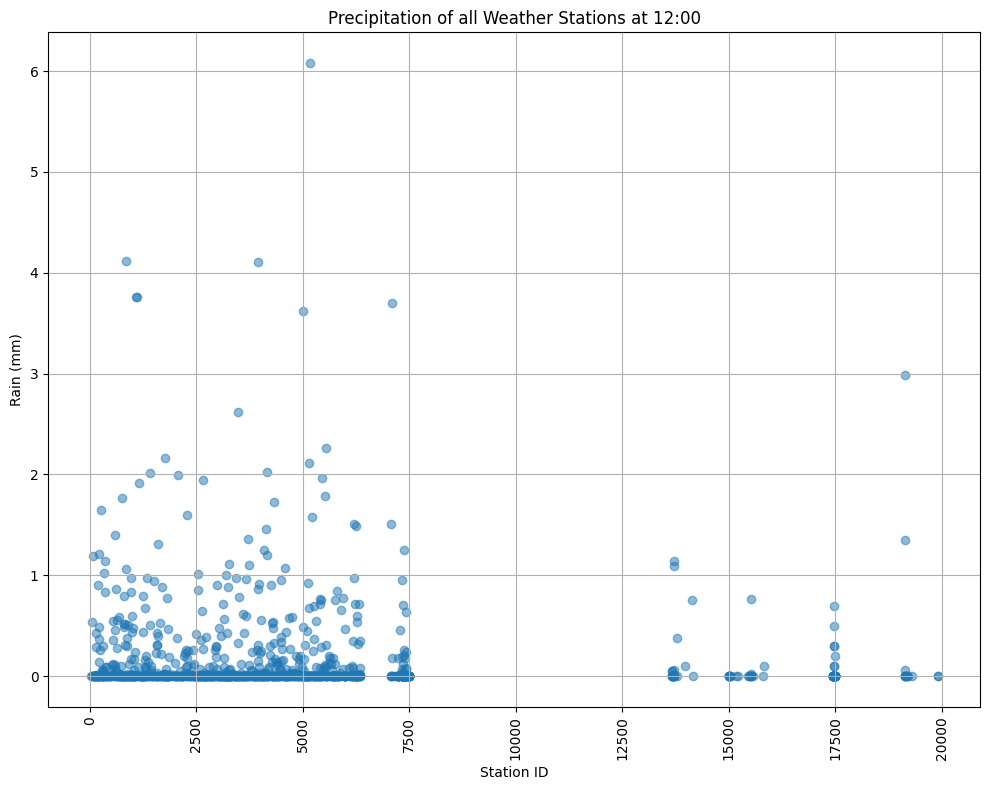

In [48]:
# Load the data
df = pd.read_csv('10min_processed.csv')

# Convert 'date' to int, then to string, and finally to datetime
df['date'] = pd.to_datetime(df['date'].apply(lambda x: str(int(x))), format='%Y%m%d%H%M')

# Replace -999 with 0 in 'rain' column
df.loc[df['rain'] == -999, 'rain'] = 0

# Set the 'date' column as index
df.set_index('date', inplace=True)

# Group by 'stationid' and resample by 60 minutes, calculating the sum of 'rain'
resampled_df = df.groupby('stationid').resample('60T')['rain'].sum().reset_index()

# Add a 'hour' column for plotting
resampled_df['hour'] = resampled_df['date'].dt.hour

# Filter for a specific hour
filtered_df = resampled_df[resampled_df['hour'] == 12] # Here I've chosen 12. Replace it with your desired hour.

# Create scatter plot
plt.figure(figsize=[10,8])
plt.scatter(filtered_df['stationid'], filtered_df['rain'], alpha=0.5)
plt.title('Precipitation of all Weather Stations at 12:00')
plt.xlabel('Station ID')
plt.ylabel('Rain (mm)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()